<a href="https://www.kaggle.com/code/bachaudhry/birdclef-25-01-exploration-preprocessing?scriptVersionId=234451592" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **BirdCLEF+ 2025 Competition - Part 1 - Data Exploration and Initial Pre-processing**

This notebook will primarily handle data exploration and initial pre-processing. 

Given this is my first time working on a multi-label audio classification task, I'll try my level best to flesh out and structure my work as best as possible in - what I imagine will be - a series of notebooks which will cover various aspects of the data preparation, model training, iteration and submission process.

Additionally, I am testing the impact of long context LLMS on my workflows and this competition will be no exception. So my work will be augmented with the support of a mixture of LLMs as I progress through the pipeline. It should be noted that as per the competition rules, I will do my level best to abide by the "Reasonableness" standards.

If anyone finds this useful then please do hit the `UPVOTE` button as a show of support.

Now, onto the task at hand....

## **Imports and Setup**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, gc, random 
from pathlib import Path
from tqdm.notebook import tqdm
import IPython.display as ipd
from IPython.display import display, clear_output
import ipywidgets as widgets

import librosa
import librosa.display
import soundfile as sf

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

In [2]:
class Config:
    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)

    def update(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)

# Initialize and set basic configuration
cfg = Config(SEED=42, SAMPLE_RATE=32000,
             DATA_PATH=Path("/kaggle/input/birdclef-2025"))

# Verifying changes
print(cfg.__dict__)

{'SEED': 42, 'SAMPLE_RATE': 32000, 'DATA_PATH': PosixPath('/kaggle/input/birdclef-2025')}


In [3]:
# Function to seed everything to ensure reproducibility
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # Change to true if input sizes are kept constant

seed_everything(cfg.SEED)

In [4]:
# Device check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## **Data Structure**

Let's attempt to review the various file types, including the metadata. According to the competition's data tab, the file `train.csv` contains the metadata we are looking for.

In [5]:
# Files in the base data path
print(f"Files in the base data path include: {os.listdir(cfg.DATA_PATH)}")

Files in the base data path include: ['sample_submission.csv', 'taxonomy.csv', 'train_audio', 'train_soundscapes', 'train.csv', 'recording_location.txt', 'test_soundscapes']


In [22]:
# Taking a closer look at the meta data
metadata_path = cfg.DATA_PATH / "train.csv"

if metadata_path.exists():
    train_df = pd.read_csv(metadata_path)
    print(train_df.head(15))
    print("\nMetadata Columns:", train_df.columns)
    print("\nTraining Samples:", len(train_df))
    print("\nUnique Species:", train_df['primary_label'].nunique())
    print("\nSecondary Species Labels(Recordist Marked):", train_df['secondary_labels'].nunique())
    # Key distributions
    print("\nSpecies distribution (top 10):")
    print(train_df[['primary_label', 'scientific_name']].value_counts().head(10))
    print("\nSpecies distribution (bottom 10):")
    print(train_df[['primary_label', 'scientific_name']].value_counts().tail(10))
else:
    print(f"Metadata file not found at {meta_datapath}. Check path!")

   primary_label              secondary_labels                    type  \
0        1139490                          ['']                    ['']   
1        1139490                          ['']                    ['']   
2        1192948                          ['']                    ['']   
3        1192948                          ['']                    ['']   
4        1192948                          ['']                    ['']   
5        1192948                          ['']                    ['']   
6        1194042                          ['']                    ['']   
7        1194042                          ['']                    ['']   
8        1194042                          ['']                    ['']   
9         126247  ['65448', '22976', '476538']  ['advertisement call']   
10        126247                          ['']                    ['']   
11        126247                          ['']                    ['']   
12        126247                      

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28564 entries, 0 to 28563
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     28564 non-null  object 
 1   secondary_labels  28564 non-null  object 
 2   type              28564 non-null  object 
 3   filename          28564 non-null  object 
 4   collection        28564 non-null  object 
 5   rating            28564 non-null  float64
 6   url               28564 non-null  object 
 7   latitude          27755 non-null  float64
 8   longitude         27755 non-null  float64
 9   scientific_name   28564 non-null  object 
 10  common_name       28564 non-null  object 
 11  author            28564 non-null  object 
 12  license           28564 non-null  object 
dtypes: float64(3), object(10)
memory usage: 2.8+ MB


Taking a closer look at the label distributions to get a better sense of class imbalances.

In [8]:
train_df.describe(include=[object])

,primary_label,secondary_labels,type,filename,collection,url,scientific_name,common_name,author,license
count,28564,28564,28564,28564,28564,28564,28564,28564,28564,28564
unique,206,745,736,28564,3,28552,206,206,2493,8
top,grekis,[''],['song'],1139490/CSA36385.ogg,XC,https://static.inaturalist.org/sounds/1020465.wav,Pitangus sulphuratus,Great Kiskadee,JAYRSON ARAUJO DE OLIVEIRA,cc-by-nc-sa 4.0
freq,990,25885,9437,1,21204,4,990,990,1780,16813


In [9]:
train_df.describe(include=[np.number])

,rating,latitude,longitude
count,28564.000000,27755.000000,27755.000000
mean,2.917063,-0.533480,-68.524380
std,1.964896,17.609276,21.614566
min,0.000000,-54.857400,-163.680000
25%,0.000000,-15.084600,-79.649200
50%,4.000000,1.131600,-73.495400
75%,4.500000,9.511000,-53.801800
max,5.000000,68.374800,153.551400


- There are 206 classes with a significant imbalance i.e. the top species `grekis` (also known by its scientific name `Pitangus sulphuratus`) has ~2x more samples than the 10th species `wbwwre1` (Henicorhina leucosticta). This also means that the top species has a representation which is orders of magnitude more than the rarest species (see distributions in the outputs above).
    - This strongly reinforces the need for modified loss functions designed to address class imbalances.
- At this stage, I'll treat location data as secondary i.e. useful for context building. This can be revisited later.
- Highly varied or _multi-taxa_ goals, as per the `taxonomy.csv` file, suggest that classification won't just be limited to birds, but will also include amphibians, mammals and insects. Thus the model architecture needs to account for this. 

## **Exploration and Pre-processing**

Key spectrogram parameters (`N_MELS`, `N_FFT`, `HOP_LENGTH`, `FMIN`, `FMAX`) will be defined in our `Config` class. These significantly impact the resulting image and model performance. Specifically:
- `N_FFT` controls frequency resolution.
- `HOP_LENGTH` controls time resolution.
- `N_MELS` is the number of frequency bins in the final Mel-spectrogram.
- `FMIN` and `FMAX` help focus on the relevant frequency range for birds.

Additionally, converting to decibels (`power_to_db`) makes faint sounds more visibile in the plots.

In [10]:
# Update config
cfg.N_MELS = 128           # number of MEL bands(can be adjusted after experimentation)
cfg.N_FFT = 2048           # window size for fast fourier transform (FFT)
cfg.HOP_LENGTH = 512       # number of samples b/w successive frames
cfg.FMIN = 50              # minimum frequency
cfg.FMAX = 14000           # maximum frequency (relevant for bird calls)
# New Clip Params
cfg.TARGET_DURATION_S = 5  # setting at 5 secs to make it easier to hear context
cfg.TARGET_SAMPLES = cfg.TARGET_DURATION_S * cfg.SAMPLE_RATE

In [11]:
# Verifying changes
print(cfg.__dict__)

{'SEED': 42, 'SAMPLE_RATE': 32000, 'DATA_PATH': PosixPath('/kaggle/input/birdclef-2025'), 'N_MELS': 128, 'N_FFT': 2048, 'HOP_LENGTH': 512, 'FMIN': 50, 'FMAX': 14000, 'TARGET_DURATION_S': 5, 'TARGET_SAMPLES': 160000}


In [12]:
# Helper function to plot waveform and spectrograms
def plot_spectrogram(waveform, sr, title="Waveform and Mel Spectrogram"):
    """Plots waveform and Mel spectrogram for a given audio signal"""
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Plot waveform
    librosa.display.waveshow(waveform, sr=sr, ax=axs[0])
    axs[0].set_title('Waveform')
    axs[0].set_ylabel('Amplitude')

    # Generate and plot Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=waveform, sr=sr,
                                                     n_fft=cfg.N_FFT,
                                                     hop_length=cfg.HOP_LENGTH,
                                                     n_mels=cfg.N_MELS,
                                                     fmin=cfg.FMIN,
                                                     fmax=cfg.FMAX)
    # Using power_to_db converts amplitude spectrogram to dB scale to improve visuals
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    img = librosa.display.specshow(mel_spectrogram_db, sr=sr, hop_length=cfg.HOP_LENGTH,
                                   x_axis='time', y_axis='mel', ax=axs[1],
                                   fmin=cfg.FMIN, fmax=cfg.FMAX)
    axs[1].set_title('Mel Spectrogram (dB)')
    axs[1].set_ylabel('Mel Frequency')
    axs[1].set_xlabel('Time (s)')
    fig.colorbar(img, ax=axs[1], format='%+2.0f dB')

    plt.suptitle(title, fontsize=17)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()
    return mel_spectrogram_db

Loading: yeofly1/XC250351.ogg; Label: yeofly1
    Original Duration: 5.43 seconds.
   Playing first 5.43 seconds:


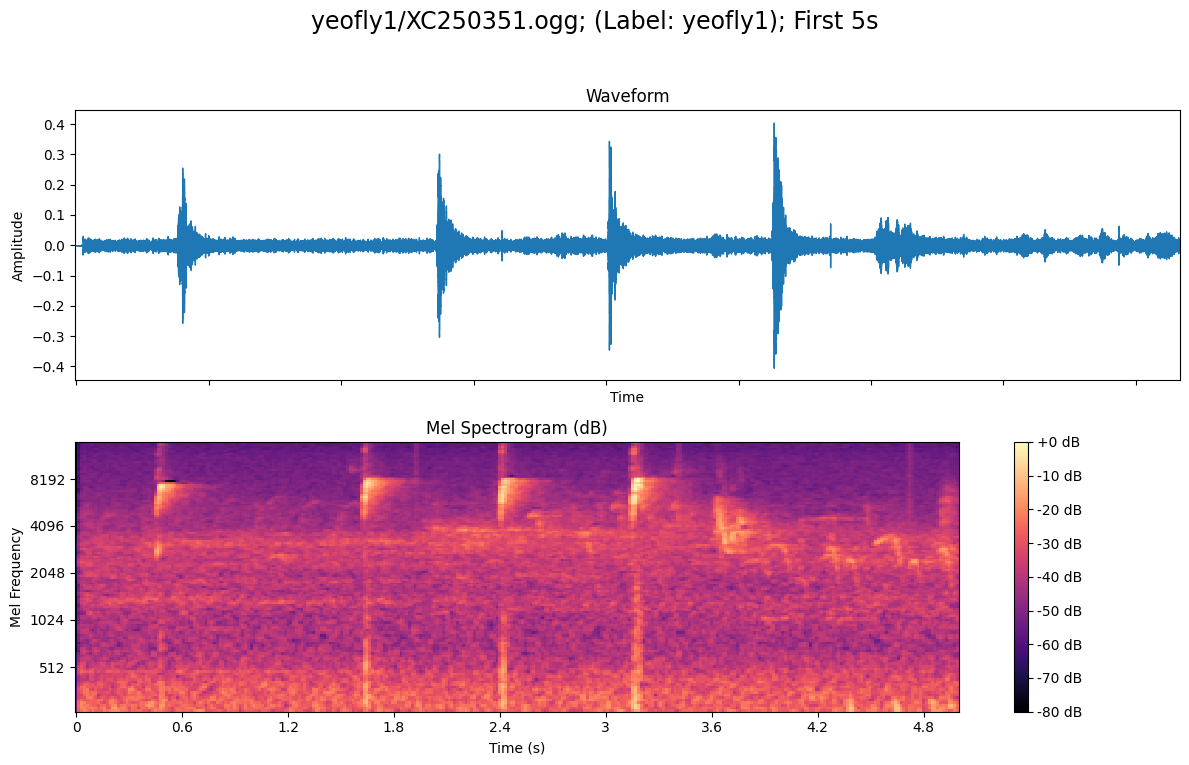

------------------------------
Loading: whbman1/XC268585.ogg; Label: whbman1
    Original Duration: 53.78 seconds.
   Playing first 10.00 seconds:


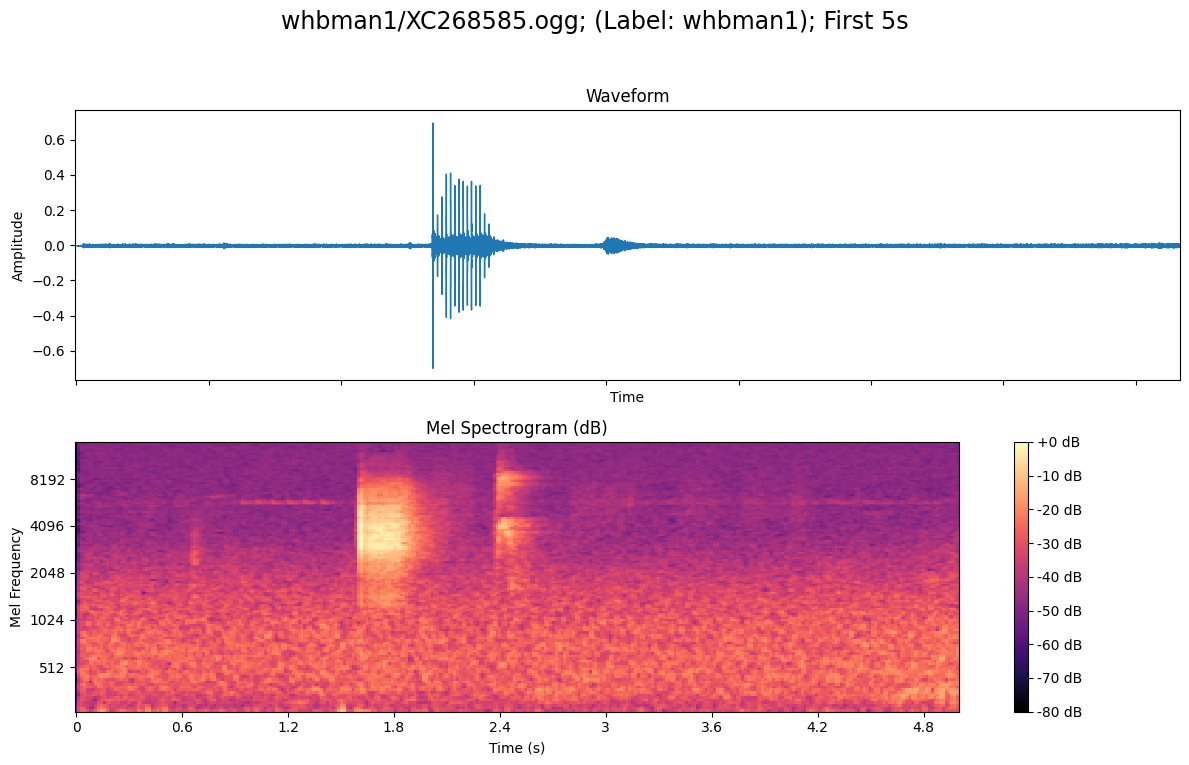

------------------------------
Loading: 21211/XC913998.ogg; Label: 21211
    Original Duration: 0.88 seconds.
   Playing first 0.88 seconds:


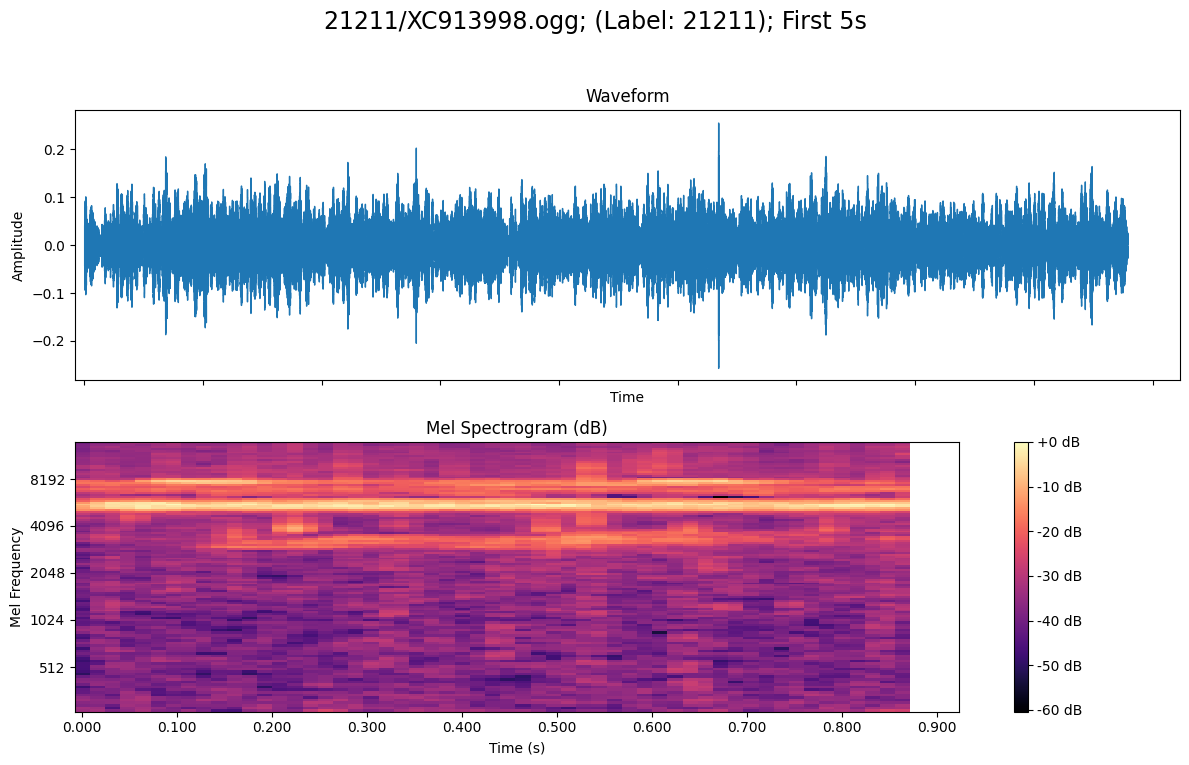

------------------------------
Loading: bugtan/XC480423.ogg; Label: bugtan
    Original Duration: 2.77 seconds.
   Playing first 2.77 seconds:


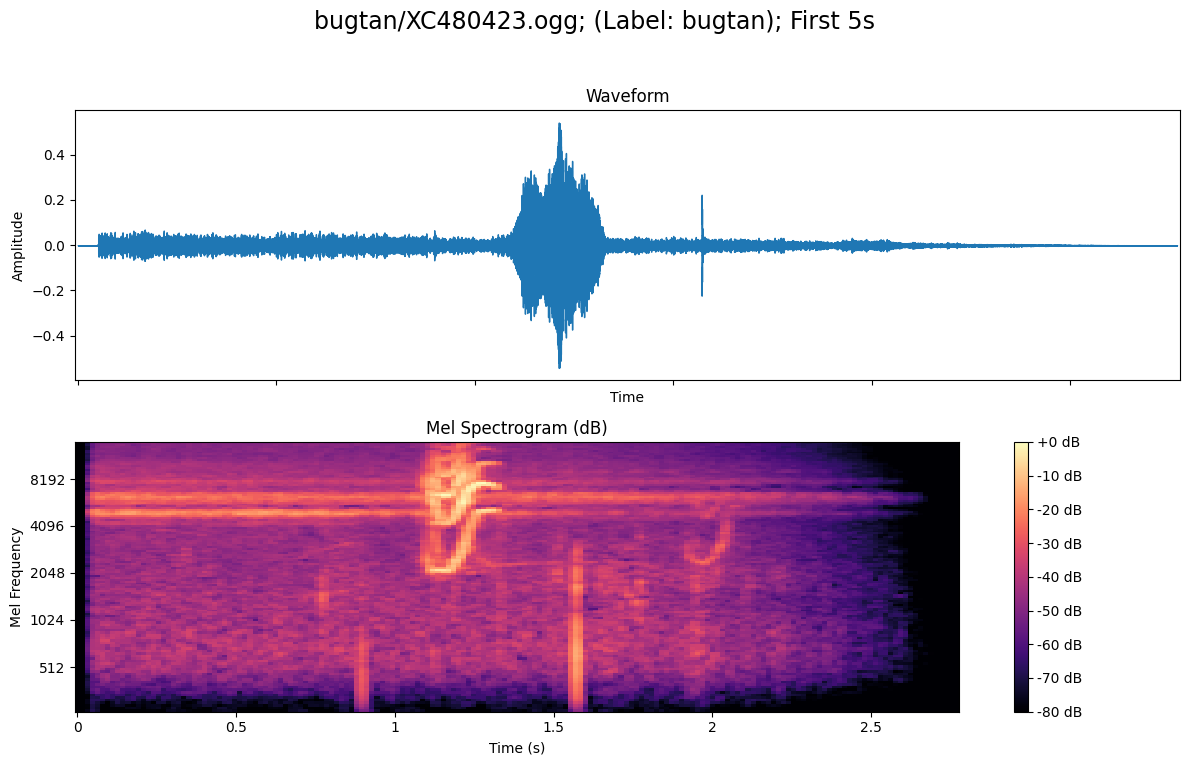

------------------------------
Loading: strher/XC287867.ogg; Label: strher
    Original Duration: 8.88 seconds.
   Playing first 8.88 seconds:


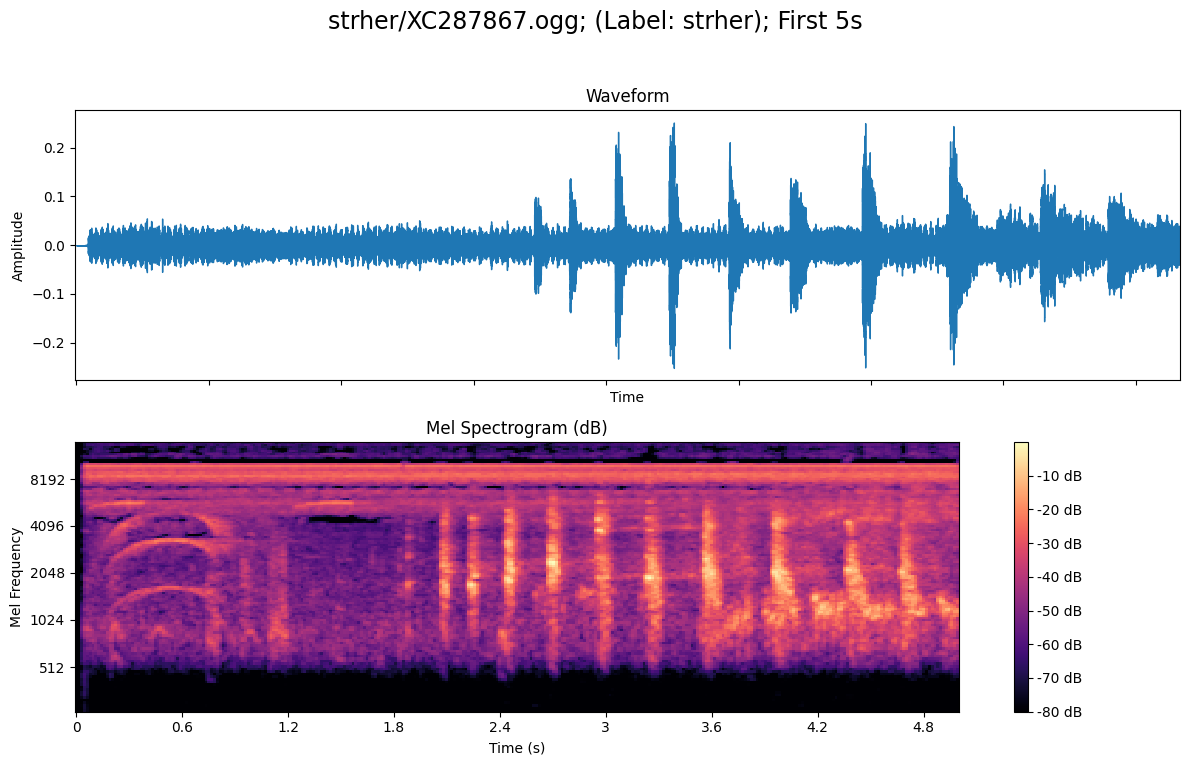

------------------------------


In [13]:
# Load and visualize a few random samples from the training data
if 'train_df' in globals() and not train_df.empty: # check of DF exists and isn't empty
    num_samples = 5
    sample_files = train_df.sample(num_samples, random_state=cfg.SEED)

    for index, row in sample_files.iterrows():
        filename = row['filename']
        label = row['primary_label']
        file_path = cfg.DATA_PATH/"train_audio"/filename

        if file_path.exists():
            print(f"Loading: {filename}; Label: {label}")
            try:
                # Load audio file and use duration=None initially to load the full file
                waveform, sr = librosa.load(file_path, sr=cfg.SAMPLE_RATE, duration=None)
                print(f"    Original Duration: {len(waveform) / sr:.2f} seconds.")

                # Play 10 sec snippet
                display_duration = min(10.0, len(waveform) / sr)
                print(f"   Playing first {display_duration:.2f} seconds:")
                ipd.display(ipd.Audio(waveform[:int(display_duration*sr)], rate=sr))

                # Plot waveform and spectrogram of the first chunk (e.g. 5 seconds)
                # Use the whole file if shorter than 5 secs
                plot_waveform, _ = librosa.load(file_path, sr=cfg.SAMPLE_RATE, duration=cfg.TARGET_DURATION_S)
                _ = plot_spectrogram(plot_waveform, cfg.SAMPLE_RATE, 
                                     title=f"{filename}; (Label: {label}); First {cfg.TARGET_DURATION_S}s")
            
            except Exception as e:
                print(f"Error processing {filename}: {e}")
            print("-" * 30)
        else:
            print(f"File not found: {file_path}")
else:
    print("Training metadata DataFrame ('train_df') not found or is empty! Skipping sample loading.")
    print("Try to manually specify some audio file paths for exploration.")
                

### **Handling Variable Audio Lengths & Segmentation**

As in the case of most deep learning models, inputs need to be of a fixed size. Audio recordings are rarely of uniform length, and our training dataset is no exception.

A common strategy is to break the original inputs into shorter, fixed length clips (for e.g. 3 or 5 seconds). This should take care of longer recordings while focusing the model on relevant short events. An added benefit of shortened clips is an increase in the number of training samples.

In [14]:
# Analyze audio durations
if 'train_df' in globals() and not train_df.empty:
    print("Analyzing audio durations...")
    durations = []
    pbar = tqdm(train_df['filename'].tolist(), desc="Calculating durations")
    for filename in pbar:
        file_path = cfg.DATA_PATH/"train_audio"/filename
        if file_path.exists():
            try:
                # Efficient approach to get duration with loading the whole file
                info = sf.info(file_path)
                durations.append(info.duration)
            except Exception as e:
                print(f"Could not get info for {filename}: {e}") #Comment / uncomment for debugging
                durations.append(np.nan) # mark errors
        else:
            durations.append(np.nan)

Analyzing audio durations...


Calculating durations:   0%|          | 0/28564 [00:00<?, ?it/s]

In [15]:
train_df['duration'] = durations # new column for durations
#train_df.dropna(subset=['duration'], inplace=True) # remove rows where duration couldn't be calculated
train_df['duration'].describe()

count    28564.000000
mean        35.352463
std         50.605646
min          0.544594
25%         10.579445
50%         20.976312
75%         41.300031
max       1774.392000
Name: duration, dtype: float64

In [16]:
train_df['duration'].isnull().sum()

0

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


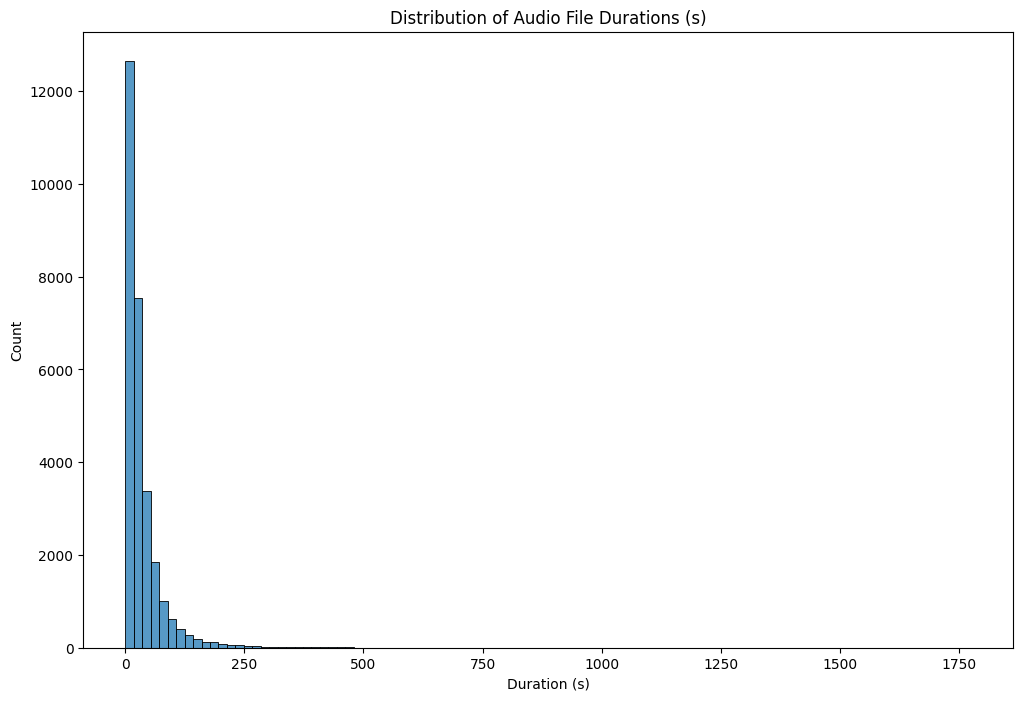

count    28564.000000
mean        35.352463
std         50.605646
min          0.544594
25%         10.579445
50%         20.976312
75%         41.300031
max       1774.392000
Name: duration, dtype: float64

Number of clips if using 5s segments (approx.):
  ~ 216,265 segments


In [17]:
plt.figure(figsize=(12, 8))
sns.histplot(train_df['duration'], bins=100)
plt.title('Distribution of Audio File Durations (s)')
plt.xlabel('Duration (s)')
plt.ylabel('Count')
plt.show()

print(train_df['duration'].describe())
print(f"\nNumber of clips if using {cfg.TARGET_DURATION_S}s segments (approx.):")
# calculate total duration / target segment duration
total_segments = np.ceil(train_df['duration'] / cfg.TARGET_DURATION_S).sum()
print(f"  ~ {int(total_segments):,} segments")

- Initial observations from the waveform and mel spectrograms reveals distinct patterns for each species with varying levels of background noise (i.e. noise of additional flora and fauna in wild settings).
- Observations also have varying levels of quality ratings (Values are 1 to 5  with 1=low quality, and 5=high quality) provided by users of Xeno-canto (0 implies no rating is available; iNaturalist and the CSA do not provide quality ratings.)

In [18]:
# Function to create fixed length clips
def create_clips(waveform, sr, clip_length_samples, overlap_samples=0, end_behavior='pad'):
    """ Splits or pads a waveform into fixed length clips"""
    clips = []
    total_samples = len(waveform)
    step = clip_length_samples - overlap_samples
    current_pos = 0

    while current_pos < total_samples:
        end_pos = current_pos + clip_length_samples
        clip = waveform[current_pos:end_pos]

        # Handle end of the waveform
        if len(clip) < clip_length_samples:
            if end_behavior == 'pad':
                padding_needed = clip_length_samples - len(clip)
                clip = np.pad(clip, (0, padding_needed), 'constant')
                clips.append(clip)
            elif end_behavior == 'truncate':
                pass # discard if the remaining part is shorter than the clip length
            elif end_behavior == 'variable':
                # Add shorter clip - requires downstream logic to handle variable sizes or padding later
                if len(clip) > 0: # Avoid empty clips if overlap > step
                    clips.append(clip)
            else:
                raise ValueError(f"Unknown end_behavior: {end_behavior}")
            break # End of waveform
        else:
            clips.append(clip)

        if step <= 0: # Avoid infinite loop if overlap >= clip_length
            raise ValueError("Overlap must be less than clip length")
        current_pos += step

        # Ensure we don't go past the end if step makes us jumpover the last samples
        # mostly relevant if overlap > 0
        if current_pos >= total_samples and end_behavior != 'variable':
            break # Prevents adding a fully paddedd clip unnecessarily when using 'pad'
    
    return clips
      


Splitting example waveform (duration: 8.88s) into    5s clips...
Generated 2 clips.
Visualizing the first generated clip:


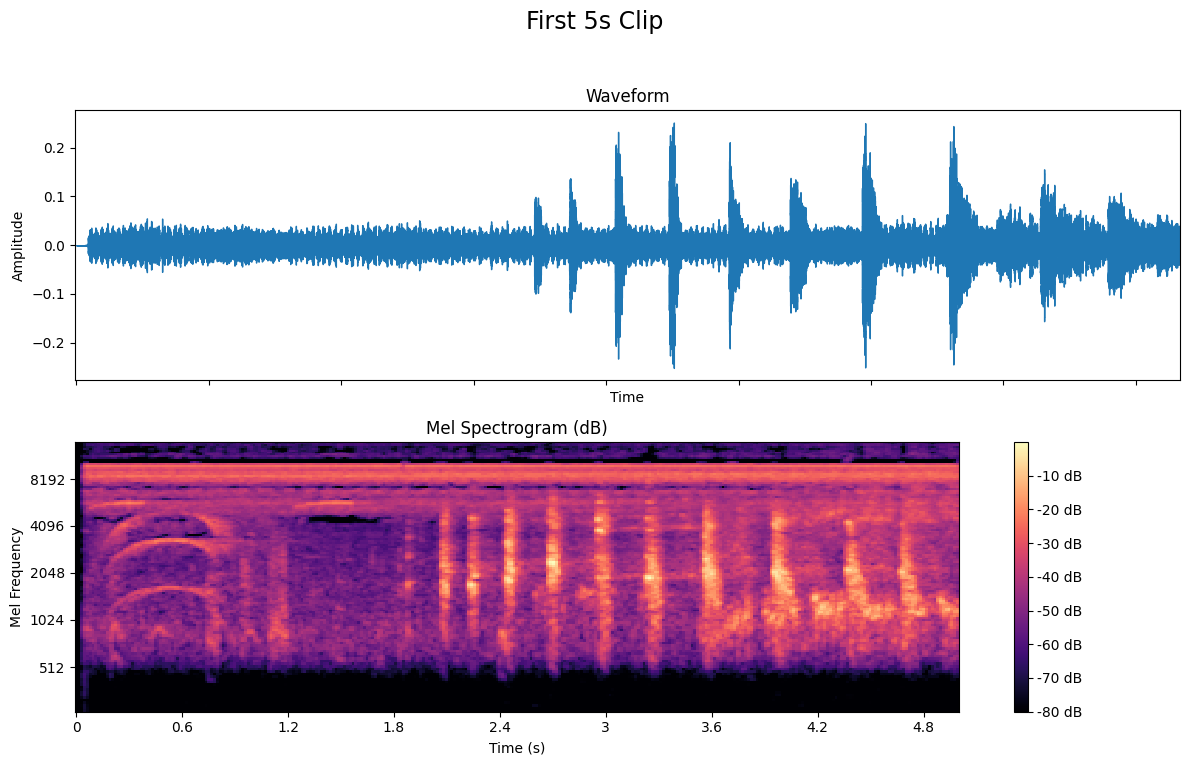

In [19]:
if 'waveform' in globals(): # last loaded waveform 
    print(f"\nSplitting example waveform (duration: {len(waveform) / cfg.SAMPLE_RATE:.2f}s) into\
    {cfg.TARGET_DURATION_S}s clips...")
    example_clips = create_clips(waveform, cfg.SAMPLE_RATE, cfg.TARGET_SAMPLES, end_behavior='pad')
    print(f"Generated {len(example_clips)} clips.")

    # Visualizing the first clip
    if example_clips:
        print("Visualizing the first generated clip:")
        _ = plot_spectrogram(example_clips[0], cfg.SAMPLE_RATE, title="First 5s Clip")
    else:
        print("No clips generated (original file may be too short).")

### **Interactive Exploration Using `ipywidgets`** (_Viewable in a Jupyter Kernel_)

We can use `ipywidgets` to quickly browse through the file folders while plotting their spectrograms. 

I am sure that most Kagglers are familiar with `ipywidgets`, but in case anyone isn't then this [notebook](https://www.kaggle.com/code/maevaralafi/diving-into-ipython-widgets/notebook) serves as an excellent guide for the uninitiated or for those who're looking to refresh their widget building skills.

In [20]:
# Setting up widget functionality while modifying the code we used to generate mel-spectrograms and waveforms
if 'train_df' in globals() and not train_df.empty:
    # Ensure duration column exists from previous steps
    if 'duration' not in train_df.columns:
        print("Warning: `duration` column not found in train_df.")
        # Limiting the size of the interactive_df for performance.
        interactive_df = train_df.sample(n=50, random_state=42) # Reduce to 50 to improve performance
    else:
        # Selecting files with a reasonable duration
        interactive_df = train_df[(train_df['duration'] >= cfg.TARGET_DURATION_S)].copy()

    if not interactive_df.empty:
        # Create drop down menu items from filenames and labels
        options = [
            (f"{row['filename']} ({row['primary_label']})", idx)
            for idx, row in interactive_df.sample(min(50, len(interactive_df)), random_state=cfg.SEED).iterrows() # Reduce to 50
        ]
        options.sort() # alphabetical sorting

        file_dropdown = widgets.Dropdown(options=options, description='Select File:')
        output_area = widgets.Output()

        def on_file_change(change):
            with output_area:
                clear_output(wait=True) # Clear previous output
                if change['new'] is not None:
                    selected_index = change['new']
                    row = interactive_df.loc[selected_index]
                    filename = row['filename']
                    label = row['primary_label']
                    file_path = cfg.DATA_PATH/"train_audio"/filename

                    if file_path.exists():
                        print(f"Loading: {filename} (Label: {label})")
                        try:
                            # Increased target duration for more context
                            waveform, sr = librosa.load(file_path, sr=cfg.SAMPLE_RATE, duration=cfg.TARGET_DURATION_S*2)
                            display(ipd.Audio(waveform[:cfg.TARGET_SAMPLES], rate=sr)) # Play first segment
                            _ = plot_spectrogram(waveform[:cfg.TARGET_SAMPLES], sr, 
                                                 title=f"{filename} ({label} - First {cfg.TARGET_DURATION_S}s)")
                        except Exception as e:
                            print(f"      Error processing {filename}: {e}")
                    else:
                        print("File not found: {file_path}")

        file_dropdown.observe(on_file_change, names='value')

        print("Interactive Spectrogram Viewer:")
        display(file_dropdown)
        display(output_area)
        
        # Trigger initial loadd for default selection
        on_file_change({'new': file_dropdown.value})
    
    else:
        print("No suitable files found for interactive exploration (duration >= 5s).")
else:
    print("Train metadata DataFrame ('train_df') not found or empty. Skipping interactive viewer.")
                            

Interactive Spectrogram Viewer:


Dropdown(description='Select File:', options=(('amekes/XC214259.ogg (amekes)', 1016), ('amekes/XC51474.ogg (am…

Output()

- The mix of both clean recordings and noisy field recordings, indicating varying SNR (signal to noise ratio), appears to be quite typical. The model needs to be robust to this noise. Which brings us back to the ratings column.
    - Ratings could potentially be used to filter out very low quality samples (e.g. rating 1) if they appear to be detrimental during training.
    - The caveat here is that there are numerous ratings with a value of 0, so we will need to be flexible with this variable.
- The positively skewed distribution of audio sample `durations` (ranging between 0.5s to ~20mins), necessitates the need for a clipping strategy, as shown above. A median of ~21s means a typical file will yeild ~4 clips of 5 seconds.
    - Clipping also gives segments with varying signal characteristics. The reason for this is that we are imposing  a fixed 5 second window constraint onto a continuous and variable audio stream. So we will end up capturing either the start, middle, end or silence between various calls.
    - Introducing this type of variability is beneficial for robustness.


With exploration and preprocessing covered for now, I'll proceed with setting up the preprocessing pipeline utility functions, dataloaders, and augmentation functions in the next notebook.